Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search
## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player **taking the last object wins**.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

## Deadlines ([AoE](https://en.wikipedia.org/wiki/Anywhere_on_Earth))

* Sunday, December 4th for Task3.1 and Task3.2
* Sunday, December 11th for Task3.3 and Task3.4
* Sunday, December 18th for all reviews

In [4]:
import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor
import random
import math
import numpy as np
import sys

## The *Nim* and *Nimply* classes

In [5]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [6]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

## Task 3.1: hardcoded strategies

In [7]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

In [8]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [9]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result


def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    #cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    #cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

In [10]:
def optimal_startegy(state: Nim) -> Nimply:
    data = cook_status(state)
    k =  next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]
    return k

In [65]:
def make_strategy(genome: dict) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)

        if random.random() < genome["p"]:
            ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        else:
            ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))

        return ply

    return evolvable

In [38]:
def big_row_strategy(state: Nim) -> Nimply:
    n_big_rows = sum(o > 1 for o in state.rows)

    if n_big_rows == 1:
        data = cook_status(state)
        for row, num_object in data['possible_moves']:
            tmp_state = deepcopy(state)
            tmp_Nimply = Nimply(row, num_object)
            tmp_state.nimming(tmp_Nimply)
            total_rows = sum([row for row in tmp_state.rows])
            if total_rows % 2 == 0:
                return tmp_Nimply
    else:
        return optimal_startegy(state)



## Strategy evaluator

In [30]:
def evaluate(strategy_player_0: Callable, strategy_player_1: Callable, N_MATCHES, NIM_SIZE) -> float:
    opponent = (strategy_player_0, strategy_player_1)
    won = 0
    for m in range(N_MATCHES):
        nim = Nim(NIM_SIZE)
        player = 0
        while sum(nim.rows) > 0:
            ply = opponent[player](nim)
            nim.nimming(ply)
            player = 1 - player
        winner = 1 - player
        if winner == 0:
            won += 1
    return won / N_MATCHES

In [42]:
N_MATCHES = 100
NIM_SIZE = 11
start = 1
evaluate(big_row_strategy,optimal_startegy, N_MATCHES, NIM_SIZE)

0.48

## Simple match between two players using different hardcoded strategies

In [44]:
logging.getLogger().setLevel(logging.DEBUG)

players_strategies = (big_row_strategy, optimal_startegy)

nim = Nim(11)
logging.debug(f"status: Initial board  -> {nim}")
player = 0
while nim:
    ply = players_strategies[player](nim)
    nim.nimming(ply)
    logging.debug(f"status: After player {player} -> {nim}")
    player = 1 - player
winner = 1 - player
logging.info(f"status: Player {winner} won!")

DEBUG:root:status: Initial board  -> <1 3 5 7 9 11 13 15 17 19 21>
DEBUG:root:status: After player 0 -> <1 3 5 7 9 11 13 15 6 19 21>
DEBUG:root:status: After player 1 -> <1 3 5 7 0 11 13 15 6 19 21>
DEBUG:root:status: After player 0 -> <1 3 5 7 0 2 13 15 6 19 21>
DEBUG:root:status: After player 1 -> <1 3 5 7 0 2 13 15 0 19 21>
DEBUG:root:status: After player 0 -> <1 3 3 7 0 2 13 15 0 19 21>
DEBUG:root:status: After player 1 -> <1 3 3 7 0 2 13 15 0 15 21>
DEBUG:root:status: After player 0 -> <1 3 3 7 0 2 13 15 0 15 9>
DEBUG:root:status: After player 1 -> <1 3 3 7 0 2 13 6 0 15 9>
DEBUG:root:status: After player 0 -> <1 3 3 7 0 2 4 6 0 15 9>
DEBUG:root:status: After player 1 -> <1 3 3 7 0 2 4 6 0 15 2>
DEBUG:root:status: After player 0 -> <1 3 3 7 0 2 4 6 0 4 2>
DEBUG:root:status: After player 1 -> <1 3 3 6 0 2 4 6 0 4 2>
DEBUG:root:status: After player 0 -> <0 3 3 6 0 2 4 6 0 4 2>
DEBUG:root:status: After player 1 -> <0 2 3 6 0 2 4 6 0 4 2>
DEBUG:root:status: After player 0 -> <0 2 2 6 

## Task 3.2

In [45]:
def make_strategy_g(genome: np.array) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        rows = np.array(state.rows)
        new_genome = genome.copy()
        rows_without_0 = rows[np.where(rows > 0)[0]]
        new_genome[np.where(rows == 0)[0]] = 2**63-1
        new_genome[np.where(new_genome == 0)[0]] = 2**63-1 ##kkk
        min_genome = min(new_genome)
        min_state = min(rows_without_0)
        id_state = random.choice(np.where(np.array(state.rows) == min_state)[0])
        if min_genome > min_state and min_state:
            ply = Nimply(id_state, int(min_state))
            return ply

        ids = np.where(genome == min_genome)[0]
        for id in ids:
            if min_genome <= state.rows[id]:
                pos_genome = id
                break
        ply = Nimply(pos_genome, int(min_genome))
        return ply

    return evolvable

Definition of class individual

In [46]:
class Individual:
    def __init__(self, genome: list):
        self.genome = np.array(genome)
        self.fitness = evaluate(make_strategy_g(self.genome), optimal_startegy, 100, NIM_SIZE)

Hyper parameters

In [47]:
POPULATION_SIZE = 10
GENOME_SIZE = NIM_SIZE = 11
NUM_GENERATIONS = 10
OFFSPRING_SIZE = 15
MUTATION_RATE = 0.35


In [48]:
nim = Nim(NIM_SIZE)

Generate population

In [49]:
population = [Individual(genome=[random.choice([i for i in range(1, nim.rows[ln]+1)]) for ln in range(NIM_SIZE)]) for i in range(POPULATION_SIZE)]

Define GA operators

In [50]:
def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def crossover(g1, g2):
    cut = random.randint(0, len(g1))
    return list(np.concatenate((g1[:cut],g2[cut:])))
    #return g1[:cut] + g2[cut:]


def mutation(g):
    point = random.randint(0, len(g) - 1)
    nim_row = nim.rows[point]
    k = [i for i in range(g[point], nim_row+1)]
    return list(np.concatenate((g[:point],np.array((random.choice(k) - g[point],)), g[point + 1 :])))
    #return g[:point] + list((1 - g[point],)) + g[point + 1 :]

GA algorithm

In [ ]:
for generation in range(NUM_GENERATIONS):
    offspring = list()
    genomes = list(map(lambda x: list(x.genome), population))
    for i in range(OFFSPRING_SIZE):
        p1 = tournament(population)
        p2 = tournament(population)
        genome = crossover(p1.genome, p2.genome)
        if random.random() < MUTATION_RATE:
             genome = mutation(genome)
        if genome not in genomes:
          individual = Individual(genome=genome)
          offspring.append(individual)
    population += offspring
    population = sorted(population, key=lambda i: i.fitness)[:POPULATION_SIZE]
    print(population[0].fitness)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)

players_strategies = (make_strategy_g(population[0].genome), optimal_startegy)

nim = Nim(NIM_SIZE)
logging.debug(f"status: Initial board  -> {nim}")
player = 0
while nim:
    ply = players_strategies[player](nim)
    nim.nimming(ply)
    logging.debug(f"status: After player {player} -> {nim}")
    player = 1 - player
winner = 1 - player
logging.info(f"status: Player {winner} won!")

## Task 3.3

In [10]:
def evaluate_state(state: Nim, player: int):
    if not state:
        if player == 1:
            return  float('-inf')
        else:
            return float('+inf')

In [11]:


def recursive_min_max(state: Nim, player):
    cache = {}
    def min_max(state, player, alpha = float('-inf'), beta = float('+inf')):
        if not state:
            return evaluate_state(state, player), None
        if (state, player) in cache:
            return cache[(state, player)]
        data = cook_status(state)
        choices = []
        for row, object in data['possible_moves']:
            tmp_state = deepcopy(state)
            tmp_Nimply = Nimply(row, object)
            tmp_state.nimming(tmp_Nimply)
            value = min_max(tmp_state, 1 - player, alpha, beta)[0]
            action = (row, object)
            choices.append((value, action))
            if player == 1:
                alpha = max(alpha, value)
            else:
                beta = min(beta, value)
            if beta <= alpha:
                break

        if player == 1:
            val = max(choices)
        else:
            val = min(choices)
        cache[(state, player)] = val
        return val

    value, action = min_max(state, player)
    return value, action


In [12]:
def minmax_strategy(state: Nim) -> Nimply:
    val, action = recursive_min_max(state, 0)
    return Nimply(action[0], action[1])

In [13]:
logging.getLogger().setLevel(logging.DEBUG)

players_strategies = (minmax_strategy, optimal_startegy)

nim = Nim(3)
logging.debug(f"status: Initial board  -> {nim}")
player = 0
while nim:
    ply = players_strategies[player](nim)
    nim.nimming(ply)
    logging.debug(f"status: After player {player} -> {nim}")
    player = 1 - player
winner = 1 - player
logging.info(f"status: Player {winner} won!")

DEBUG:root:status: Initial board  -> <1 3 5>
DEBUG:root:status: After player 0 -> <1 3 2>
DEBUG:root:status: After player 1 -> <0 3 2>
DEBUG:root:status: After player 0 -> <0 2 2>
DEBUG:root:status: After player 1 -> <0 0 2>
DEBUG:root:status: After player 0 -> <0 0 0>
INFO:root:status: Player 0 won!


## Task 3.4

In [77]:
class Nim:
    def __init__(self, num_rows: int, k: int = None, rows = None) -> None:
        if rows:
            self._rows = rows
        else:
            self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k
        self._num_rows = num_rows
        self.row_states = []

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def num_rows(self):
        return self._num_rows

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

    def is_game_over(self):
        return not (sum(self._rows) > 0)

    def give_rewards(self):
        return -1* (sum(self._rows) > 0)

    def get_state_and_reward(self):
        return self, self.give_rewards()

    def is_allowed_move(self, ply):
        row, num_objects = ply
        return self._rows[row] >= num_objects and (self._k is None or num_objects <= self._k)

    def allowed_moves(self):
        return [(row, obj) for row, c in enumerate(self.rows) for obj in range(1, c + 1)]

    def generate_row_state(self):
        current_state_row = deepcopy(self._rows)
        self.row_states.append(tuple(current_state_row))

        def recursive_generation(current_state_row, pos):
            if current_state_row == 0:
                return

            for pos in range(pos, self._num_rows):
                max = current_state_row[pos]
                for rm_elm in range(1,max+1):
                    new_state = deepcopy(current_state_row)
                    new_state[pos] -= rm_elm
                    self.row_states.append(tuple(new_state))
                    recursive_generation(new_state, pos + 1)

        recursive_generation(current_state_row, 0)
        return self.row_states

In [92]:


class Agent():

    def __init__(self, nim, alpha = 0.1, random_factor = 0.2) -> None:
        self.state_history = []
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(nim)

    def init_reward(self, state: Nim):
        row_states = state.generate_row_state()
        print(row_states)
        for row_state in row_states:
            self.G[row_state] = np.random.uniform(low=1.0, high=0.1)

    def choose_action(self, state: Nim) -> Nimply:
        maxG = -10e15
        next_move = None
        possible_moves = state.allowed_moves()
        if np.random.random() < self.random_factor:
            next_move = random.choice(possible_moves)
        else:
            for action in possible_moves:
                new_state = deepcopy(state)
                new_state.nimming(action)
                if self.G[new_state.rows] >= maxG:
                    next_move = action
                    maxG = self.G[new_state.rows]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev.rows] = (1 - self.alpha)*self.G[prev.rows] + self.alpha * (target - self.G[prev.rows])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5

    def get_strategy(self) -> Callable:
        def agent_strategy(state: Nim) -> Nimply:
            action = self.choose_action(state)
            return Nimply(action[0], action[1])
        return agent_strategy


In [108]:
evaluation_history = []
NUM_EPOCHS = 5000
NIM_SIZE = 3
N_MATCHES = 100

nim = Nim(NIM_SIZE)
robot = Agent(nim, alpha=0.9, random_factor=0.2)

def rl_strategy(nim: Nim):
    state, _ = nim.get_state_and_reward()
    action = robot.choose_action(state)
    state, reward = nim.get_state_and_reward()
    robot.update_state_history(state, reward)
    return action

for i in range(NUM_EPOCHS):
    player = 0
    opponent_strategy = (rl_strategy, optimal_startegy)
    while not nim.is_game_over():
        ply = opponent_strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    winner = 1 - player
    robot.learn()
    if i % 50 == 0:
        eval = evaluate(robot.get_strategy(), optimal_startegy, N_MATCHES, NIM_SIZE)
        evaluation_history.append(eval)
        print(f"#{i}: {eval}")
    nim = Nim(NIM_SIZE)

[(1, 3, 5), (0, 3, 5), (0, 2, 5), (0, 2, 4), (0, 2, 3), (0, 2, 2), (0, 2, 1), (0, 2, 0), (0, 1, 5), (0, 1, 4), (0, 1, 3), (0, 1, 2), (0, 1, 1), (0, 1, 0), (0, 0, 5), (0, 0, 4), (0, 0, 3), (0, 0, 2), (0, 0, 1), (0, 0, 0), (0, 3, 4), (0, 3, 3), (0, 3, 2), (0, 3, 1), (0, 3, 0), (1, 2, 5), (1, 2, 4), (1, 2, 3), (1, 2, 2), (1, 2, 1), (1, 2, 0), (1, 1, 5), (1, 1, 4), (1, 1, 3), (1, 1, 2), (1, 1, 1), (1, 1, 0), (1, 0, 5), (1, 0, 4), (1, 0, 3), (1, 0, 2), (1, 0, 1), (1, 0, 0), (1, 3, 4), (1, 3, 3), (1, 3, 2), (1, 3, 1), (1, 3, 0)]
#0: 0.0
#50: 0.0
#100: 0.0
#150: 0.0
#200: 0.0
#250: 0.0
#300: 0.0
#350: 0.0
#400: 0.0
#450: 0.0
#500: 0.01
#550: 0.0
#600: 0.01
#650: 0.01
#700: 0.01
#750: 0.0
#800: 0.01
#850: 0.0
#900: 0.0
#950: 0.0
#1000: 0.0
#1050: 0.0
#1100: 0.01
#1150: 0.0
#1200: 0.0
#1250: 0.0
#1300: 0.0
#1350: 0.0
#1400: 0.0
#1450: 0.0
#1500: 0.0
#1550: 0.0
#1600: 0.0
#1650: 0.0
#1700: 0.0
#1750: 0.0
#1800: 0.0
#1850: 0.0
#1900: 0.0
#1950: 0.0
#2000: 0.0
#2050: 0.0
#2100: 0.0
#2150: 0.0
#220

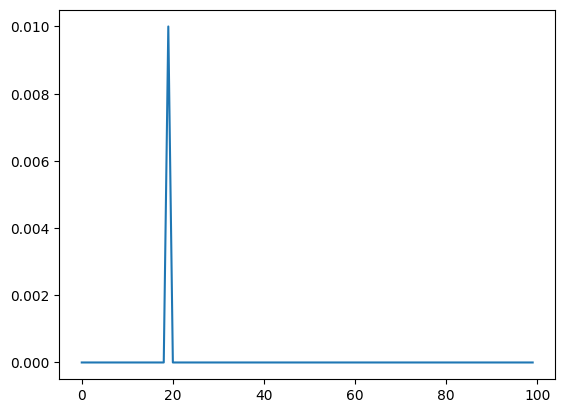

In [105]:
from matplotlib import pyplot as plt
plt.plot(evaluation_history)
plt.show()